In [1]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from matplotlib.image import imread
import pandas as pd
from PIL import Image
import cv2

In [2]:
import zipfile
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
import warnings

In [4]:
zip_path = 'FracAtlas.zip'
extract_dir = 'fracatlas_extracted'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

images_dir = os.path.join(extract_dir, 'FracAtlas/images')
annotations_dir = os.path.join(extract_dir, 'FracAtlas/Annotations/YOLO')

In [5]:
# Checked to see if each image has a corresponding label

categories = ['Fractured', 'Non_fractured']

for cat in categories:
    category_path = os.path.join(images_dir, cat)
    
    for img_file in os.listdir(category_path):
        if img_file.endswith(('.jpg', '.jpeg', '.png')):
            img_name = os.path.splitext(img_file)[0]
            annotation_file = img_name + '.txt'
            annotation_path = os.path.join(annotations_dir, annotation_file)

            # if os.path.exists(annotation_path):
            #     print(f"Found annotation for {img_file}: {annotation_path}")
            # else:
            #     print(f"No annotation found for {img_file} at {annotation_path}.")

In [7]:
# Organize the data into {"inputs": images, "labels": labels} structure!

images_dir = 'fracatlas_extracted/FracAtlas/images'
annotations_dir = 'fracatlas_extracted/FracAtlas/Annotations/YOLO'

images = []
labels = []

for category in os.listdir(images_dir):
    category_path = os.path.join(images_dir, category)
    
    if not os.path.isdir(category_path):
        continue 

    for img_file in os.listdir(category_path):
        if img_file.endswith(('.jpg', '.jpeg', '.png')): 
            img_name = os.path.splitext(img_file)[0]
            annotation_file = img_name + '.txt'
            annotation_path = os.path.join(annotations_dir, annotation_file)

            if os.path.exists(annotation_path):
                img_path = os.path.join(category_path, img_file)
                images.append(img_path)
                labels.append(category)
            else:
                print(f"No annotation found for {img_file} at {annotation_path}.")

data_dict_old = {
    "inputs": images,
    "labels": labels
}

print(f"{len(images)} image paths and {len(labels)} labels in organized data")

4083 image paths and 4083 labels in organized data


In [8]:
# Do not include corrupted/damaged images

def preprocess(img_path):
    try:
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = img_array / 255.0 # normalize pixel values
        return img_array
    except (OSError, IOError) as e:
        warnings.warn(f"Skipping corrupted image: {img_path}. Error: {e}")
        return None

images = []
labels = []

for img_path, label in zip(data_dict_old["inputs"], data_dict_old["labels"]):
    img = preprocess(img_path)
    if img is not None:
        images.append(img)
        labels.append(label)

images = np.array(images)
labels = np.array(labels)

data_dict = {
    "inputs": images,
    "labels": labels
}

print(f"{len(images)}/{len(data_dict_old['inputs'])} images processed")

/var/folders/nn/y53xr9md50dbbcwstvbhq_c00000gn/T/ipykernel_12656/2169368734.py:10: UserWarning: Skipping corrupted image: fracatlas_extracted/FracAtlas/images/Non_fractured/IMG0004036.jpg. Error: image file is truncated (14 bytes not processed)
  warnings.warn(f"Skipping corrupted image: {img_path}. Error: {e}")
/var/folders/nn/y53xr9md50dbbcwstvbhq_c00000gn/T/ipykernel_12656/2169368734.py:10: UserWarning: Skipping corrupted image: fracatlas_extracted/FracAtlas/images/Non_fractured/IMG0004142.jpg. Error: image file is truncated (32 bytes not processed)
  warnings.warn(f"Skipping corrupted image: {img_path}. Error: {e}")
/var/folders/nn/y53xr9md50dbbcwstvbhq_c00000gn/T/ipykernel_12656/2169368734.py:10: UserWarning: Skipping corrupted image: fracatlas_extracted/FracAtlas/images/Non_fractured/IMG0004194.jpg. Error: image file is truncated (10 bytes not processed)
  warnings.warn(f"Skipping corrupted image: {img_path}. Error: {e}")
/var/folders/nn/y53xr9md50dbbcwstvbhq_c00000gn/T/ipykernel

4024/4083 images processed


In [9]:
# Encode the output labels to be 0 or 1

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(data_dict["labels"])
data_dict["encoded_labels"] = encoded_labels

In [8]:
#image.load_img("fracatlas_extracted/FracAtlas/images/Non_fractured/IMG0004189.jpg", target_size=(224, 224))

In [9]:
#fracatlas_extracted/FracAtlas/Annotations/YOLO/IMG0000008.txt
#fracatlas_extracted/FracAtlas/images/Non_fractured/IMG0000008.jpg

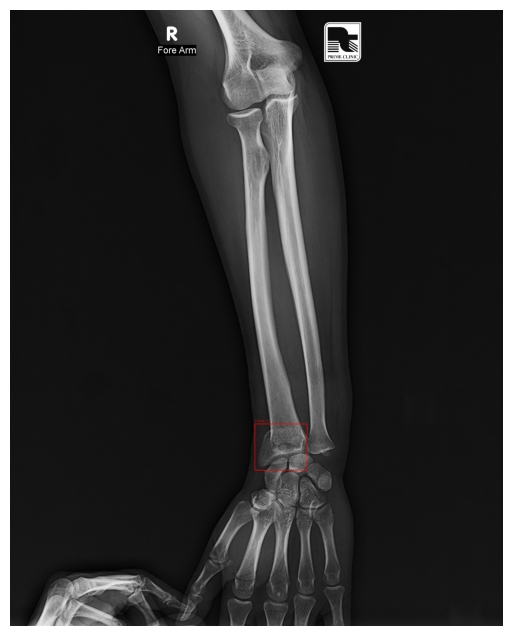

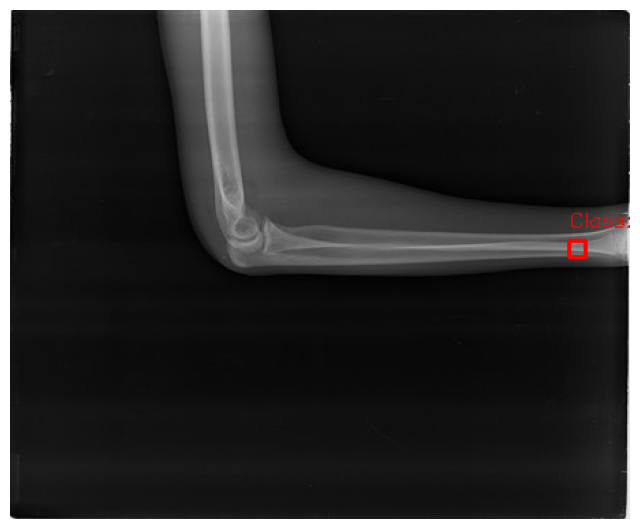

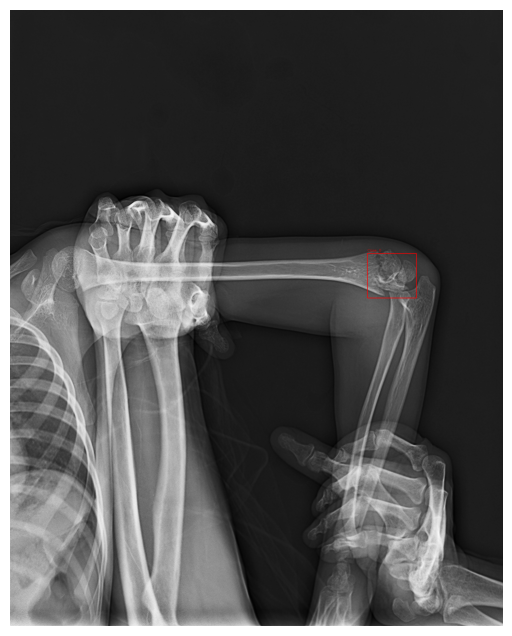

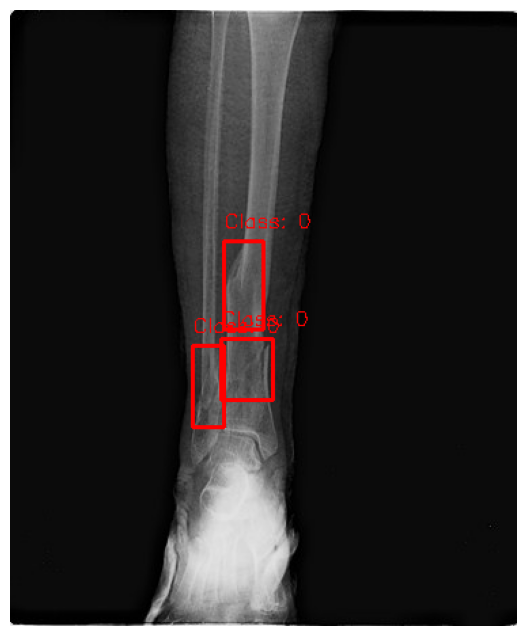

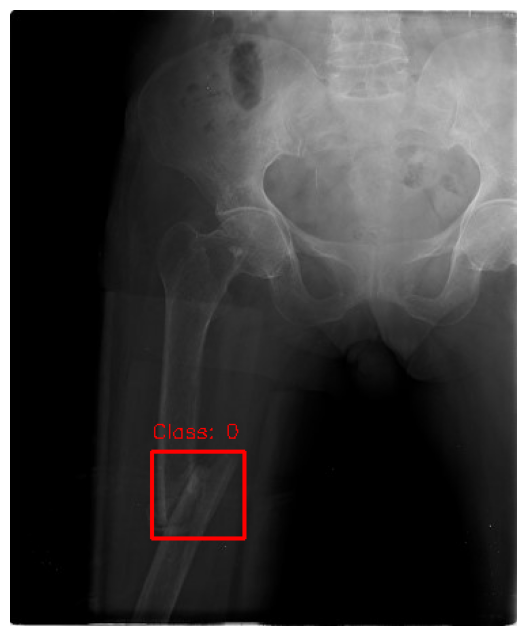

In [12]:
# Function to overlay bounding boxes on images
def draw_bounding_boxes(img_path, annotation_path, save_dir=None):
    # Loading the image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_height, img_width, _ = img.shape

    # Checking if annotation exists
    if not os.path.exists(annotation_path):
        warnings.warn(f"Annotation file {annotation_path} not found. Skipping.")
        return None

    # Reading YOLO annotations
    with open(annotation_path, 'r') as file:
        lines = file.readlines()
    
    for line in lines:

        # YOLO format: class_id, x_center, y_center, width, height (all relative)
        parts = line.strip().split()
        if len(parts) != 5:
            warnings.warn(f"Invalid annotation format in {annotation_path}. Skipping.")
            continue
        
        class_id, x_center, y_center, width, height = map(float, parts)
        
        # Converting relative coordinates to absolute pixel values
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height
        
        # Calculating box corners
        x_min = int(x_center - width / 2)
        y_min = int(y_center - height / 2)
        x_max = int(x_center + width / 2)
        y_max = int(y_center + height / 2)
        
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        
        cv2.putText(img, f"Class: {int(class_id)}", (x_min, y_min - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, os.path.basename(img_path))
        plt.imsave(save_path, img)
    
    plt.show()

for img_path, label in zip(data_dict_old["inputs"][:5], data_dict_old["labels"][:5]): 
    
    img_name = os.path.splitext(os.path.basename(img_path))[0]
    annotation_path = os.path.join(annotations_dir, img_name + '.txt')
    
    draw_bounding_boxes(img_path, annotation_path)
